In [1]:
from pathlib import Path
import pandas as pd
from IPython.display import display

BASE = Path("bumperanalysis")   # folder containing the .pm2 files you listed

files = {
    "Cecil Hall": [
        "(OBIX) 7thFlrCecilHall.pm2",
    ],
    "Fraktur": [
        "(OBIX) Fraktur.pm2",
        "FRAKTUR ROOM.pm2",
        "FRAKTUR ROOM - 2011 ONWARD.pm2",
    ],
    "Readbourne Passage": [
        "(OBIX) ReadbornePassage.pm2",  
        "(OBIX) ReadbournePassage.pm2",
    ],
    "Nemours": [
        "(OBIX) Nemours.pm2",
    ],
    "Readbourne Room": [
       
    ],
}



In [2]:
def load_pm2_fixed(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=4, sep=r"\s+", header=None,
                     names=["Date", "Time", "Temp_F", "RH"])
    df["Timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")
    df["Temp_F"] = pd.to_numeric(df["Temp_F"], errors="coerce")
    df["RH"]     = pd.to_numeric(df["RH"], errors="coerce")
    df = df[["Timestamp", "Temp_F", "RH"]].dropna(subset=["Timestamp"]).sort_values("Timestamp")
    return df

room_df = {}
for room, flist in files.items():
    parts = []
    for fn in flist:
        p = BASE / fn
        if p.exists():
            parts.append(load_pm2_fixed(p))
        else:
            print(f"Missing: {fn}")
    if parts:
        df = (pd.concat(parts, ignore_index=True)
                .sort_values("Timestamp")
                .drop_duplicates(subset=["Timestamp"])
                .reset_index(drop=True))
        # optional sanity clip
        df = df[(df["Temp_F"].between(40, 100)) | df["Temp_F"].isna()]
        room_df[room] = df

# Quick summary + head
for name, df in room_df.items():
    print(f"\n===== {name} =====")
    print(f"Rows: {len(df):,} | Coverage: {df['Timestamp'].min()} → {df['Timestamp'].max()}")
    print("Columns:", df.columns.tolist())
    print(df["Temp_F"].describe())
    display(df.head())


===== Cecil Hall =====
Rows: 335,533 | Coverage: 2013-07-09 14:45:00 → 2025-01-07 17:15:00
Columns: ['Timestamp', 'Temp_F', 'RH']
count    335533.000000
mean         69.813390
std           2.369739
min          60.300000
25%          67.800000
50%          70.100000
75%          71.800000
max          78.400000
Name: Temp_F, dtype: float64


,Timestamp,Temp_F,RH
0,2013-07-09 14:45:00,71.5,53
1,2013-07-09 15:00:00,71.5,52
2,2013-07-09 15:15:00,71.5,52
3,2013-07-09 15:30:00,71.4,52
4,2013-07-09 15:45:00,71.5,52



===== Fraktur =====
Rows: 366,755 | Coverage: 2009-09-04 15:59:00 → 2025-01-07 16:45:00
Columns: ['Timestamp', 'Temp_F', 'RH']
count    366755.000000
mean         68.976236
std           2.277083
min          57.000000
25%          67.300000
50%          68.800000
75%          70.500000
max          77.600000
Name: Temp_F, dtype: float64


,Timestamp,Temp_F,RH
0,2009-09-04 15:59:00,69.4,53
1,2009-09-04 16:01:00,69.3,53
2,2009-09-04 16:03:00,69.3,53
3,2009-09-04 16:06:00,69.3,53
4,2009-09-04 16:08:00,69.3,53



===== Readbourne Passage =====
Rows: 339,494 | Coverage: 2013-07-09 14:45:00 → 2025-01-07 17:15:00
Columns: ['Timestamp', 'Temp_F', 'RH']
count    339494.000000
mean         68.563497
std           2.033596
min          40.000000
25%          67.400000
50%          68.900000
75%          70.000000
max          92.900000
Name: Temp_F, dtype: float64


,Timestamp,Temp_F,RH
0,2013-07-09 14:45:00,69.0,55
1,2013-07-09 15:00:00,69.1,54
2,2013-07-09 15:15:00,69.0,54
3,2013-07-09 15:30:00,69.1,54
4,2013-07-09 15:45:00,69.0,54



===== Nemours =====
Rows: 337,010 | Coverage: 2013-04-20 09:15:00 → 2025-01-07 17:15:00
Columns: ['Timestamp', 'Temp_F', 'RH']
count    337010.000000
mean         69.058498
std           1.920545
min          58.200000
25%          67.600000
50%          68.900000
75%          70.400000
max          76.100000
Name: Temp_F, dtype: float64


,Timestamp,Temp_F,RH
0,2013-04-20 09:15:00,67.2,50
1,2013-04-23 16:15:00,65.5,39
2,2013-04-23 16:30:00,65.6,39
3,2013-04-23 16:45:00,65.4,39
4,2013-04-23 17:00:00,65.5,39


In [3]:
import pandas as pd

GAP_MIN = 60  # minutes

def gap_table(df: pd.DataFrame, thresh_min=GAP_MIN) -> pd.DataFrame:
    s = df["Timestamp"].sort_values().reset_index(drop=True)
    gaps = s.diff().dt.total_seconds().div(60)  # minutes
    idx = gaps[gaps > thresh_min].index

    rows = []
    for i in idx:
        t1 = s.iloc[i-1] if i > 0 else pd.NaT   # previous timestamp
        t2 = s.iloc[i]                           # current timestamp
        gap_min = gaps.iloc[i]
        rows.append({
            "Gap Start": t1,
            "Gap End": t2,
            "Duration (min)": gap_min,
            "Duration (hours)": round(gap_min/60, 2),
            "Duration (days)": round(gap_min/1440, 2),
        })
    out = pd.DataFrame(rows).sort_values("Gap Start").reset_index(drop=True)
    return out

# Run for every room in your parsed dict (room_df)
gap_results = {}
for room, df in room_df.items():
    gt = gap_table(df, thresh_min=GAP_MIN)
    gap_results[room] = gt
    print(f"\n===== {room} =====")
    print(f"Gaps > {GAP_MIN} min: {len(gt)}")
    if len(gt):
        display(gt.head(10))  # show first few
    else:
        print("✅ No gaps above threshold.")

# Optional: combine all rooms into one table for export or sorting
all_gaps = (pd.concat(
    [g.assign(Room=room) for room, g in gap_results.items()],
    ignore_index=True
).sort_values(["Room", "Gap Start"]))



===== Cecil Hall =====
Gaps > 60 min: 109


,Gap Start,Gap End,Duration (min),Duration (hours),Duration (days)
0,2013-07-11 15:00:00,2013-07-11 18:15:00,195.0,3.25,0.14
1,2013-07-12 10:30:00,2013-07-12 13:00:00,150.0,2.50,0.10
2,2013-07-12 13:45:00,2013-07-12 18:15:00,270.0,4.50,0.19
3,2013-07-17 12:15:00,2013-07-17 15:15:00,180.0,3.00,0.12
4,2013-07-20 21:00:00,2013-07-20 22:30:00,90.0,1.50,0.06
5,2013-07-30 05:30:00,2013-07-30 09:15:00,225.0,3.75,0.16
6,2013-08-06 11:30:00,2013-08-06 15:00:00,210.0,3.50,0.15
7,2013-08-30 11:45:00,2013-08-30 15:30:00,225.0,3.75,0.16
8,2013-08-31 14:00:00,2013-08-31 15:30:00,90.0,1.50,0.06
9,2013-09-25 16:45:00,2013-09-25 20:15:00,210.0,3.50,0.15



===== Fraktur =====
Gaps > 60 min: 3172


,Gap Start,Gap End,Duration (min),Duration (hours),Duration (days)
0,2009-09-27 06:09:00,2011-11-09 19:01:00,1113892.0,18564.87,773.54
1,2011-11-09 19:01:00,2011-11-09 23:01:00,240.0,4.00,0.17
2,2011-11-09 23:01:00,2011-11-10 03:01:00,240.0,4.00,0.17
3,2011-11-10 03:01:00,2011-11-10 07:01:00,240.0,4.00,0.17
4,2011-11-10 07:01:00,2011-11-10 11:01:00,240.0,4.00,0.17
5,2011-11-10 11:01:00,2011-11-10 15:01:00,240.0,4.00,0.17
6,2011-11-10 15:01:00,2011-11-10 19:01:00,240.0,4.00,0.17
7,2011-11-10 19:01:00,2011-11-10 23:01:00,240.0,4.00,0.17
8,2011-11-10 23:01:00,2011-11-11 03:01:00,240.0,4.00,0.17
9,2011-11-11 03:01:00,2011-11-11 07:01:00,240.0,4.00,0.17



===== Readbourne Passage =====
Gaps > 60 min: 143


,Gap Start,Gap End,Duration (min),Duration (hours),Duration (days)
0,2013-07-09 23:00:00,2013-07-10 11:15:00,735.0,12.25,0.51
1,2013-07-10 23:15:00,2013-07-11 04:45:00,330.0,5.50,0.23
2,2013-07-12 09:15:00,2013-07-12 10:30:00,75.0,1.25,0.05
3,2013-07-13 13:15:00,2013-07-13 16:15:00,180.0,3.00,0.12
4,2013-07-14 08:30:00,2013-07-14 14:45:00,375.0,6.25,0.26
5,2013-07-16 15:15:00,2013-07-16 18:00:00,165.0,2.75,0.11
6,2013-07-16 19:00:00,2013-07-17 02:00:00,420.0,7.00,0.29
7,2013-11-03 05:45:00,2013-11-03 07:00:00,75.0,1.25,0.05
8,2013-11-14 23:15:00,2013-11-15 01:45:00,150.0,2.50,0.10
9,2013-11-15 01:45:00,2013-11-15 03:45:00,120.0,2.00,0.08



===== Nemours =====
Gaps > 60 min: 145


,Gap Start,Gap End,Duration (min),Duration (hours),Duration (days)
0,2013-04-20 09:15:00,2013-04-23 16:15:00,4740.0,79.00,3.29
1,2013-04-23 21:15:00,2013-04-23 23:45:00,150.0,2.50,0.10
2,2013-05-10 09:30:00,2013-05-10 11:30:00,120.0,2.00,0.08
3,2013-05-10 17:45:00,2013-05-10 20:45:00,180.0,3.00,0.12
4,2013-05-11 11:45:00,2013-05-11 14:45:00,180.0,3.00,0.12
5,2013-05-11 15:30:00,2013-05-11 18:15:00,165.0,2.75,0.11
6,2013-05-11 18:30:00,2013-05-11 20:30:00,120.0,2.00,0.08
7,2013-05-12 03:30:00,2013-05-12 09:45:00,375.0,6.25,0.26
8,2013-05-12 10:00:00,2013-05-12 11:15:00,75.0,1.25,0.05
9,2013-05-12 18:45:00,2013-05-13 11:15:00,990.0,16.50,0.69


In [5]:
THRESHOLD = 75

for room in daily["Room"].unique():
    sub = daily[daily["Room"] == room].copy()
    sub["Date"] = pd.to_datetime(sub["Date"])
    
    plt.figure(figsize=(10,4))
    plt.plot(sub["Date"], sub["DailyMean_F"], color="skyblue", linewidth=2, label="Daily Mean Temp")
    
    # Highlight hot days
    hot = sub[sub["DailyMean_F"] > THRESHOLD]
    plt.scatter(hot["Date"], hot["DailyMean_F"], color="red", s=25, label=">75°F Days")
    
    plt.axhline(THRESHOLD, color="orange", linestyle="--", linewidth=1)
    plt.title(f"{room} — Daily Mean Temperature Over Time")
    plt.ylabel("Temperature (°F)")
    plt.xlabel("Date")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

NameError: name 'daily' is not defined

In [8]:
TZ_LOCAL = "America/New_York"

def _fix_time_24h(s: pd.Series) -> pd.Series:
    return s.str.replace(r"\b24:00\b", "23:59:59", regex=True)

def load_pm2_fixed(path: Path) -> pd.DataFrame:
    # Header is always 4 lines in your sample
    df = pd.read_csv(
        path,
        skiprows=4,
        sep=r"\s+",
        header=None,
        names=["Date", "Time", "Temp_F", "RH"],
        dtype={"Date":"string","Time":"string","Temp_F":"string","RH":"string"},
        engine="python",
    )
    # Clean + parse
    df["Time"] = _fix_time_24h(df["Time"].str.strip())
    df["Timestamp"] = pd.to_datetime(df["Date"].str.strip() + " " + df["Time"], errors="coerce")

    df["Temp_F"] = pd.to_numeric(df["Temp_F"], errors="coerce")
    df["RH"]     = pd.to_numeric(df["RH"], errors="coerce")

    # Keep valid rows
    df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp").reset_index(drop=True)

    # The file is in GMT → localize to UTC, then convert to local time
    df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert(TZ_LOCAL)

    # Reasonable sanity clip
    df.loc[df["Temp_F"].notna(), "Temp_F"] = df.loc[df["Temp_F"].notna(), "Temp_F"].clip(40, 100)

    # helpers
    df["DateOnly"]  = df["Timestamp"].dt.date
    df["Year"]      = df["Timestamp"].dt.year
    df["Month"]     = df["Timestamp"].dt.month
    df["MonthName"] = df["Timestamp"].dt.strftime("%Y-%m")
    return df


In [9]:
for r, d in room_df.items():
    print(r, "| rows:", len(d), "| first:", d["Timestamp"].min(), "| last:", d["Timestamp"].max())
    print(d.head(3))


Cecil Hall | rows: 0 | first: NaT | last: NaT
Empty DataFrame
Columns: [Timestamp, Temp_F, RH, DateOnly, Year, Month, MonthName]
Index: []
Fraktur | rows: 0 | first: NaT | last: NaT
Empty DataFrame
Columns: [Timestamp, Temp_F, RH, DateOnly, Year, Month, MonthName]
Index: []
Readbourne Passage | rows: 0 | first: NaT | last: NaT
Empty DataFrame
Columns: [Timestamp, Temp_F, RH, DateOnly, Year, Month, MonthName]
Index: []
Nemours | rows: 0 | first: NaT | last: NaT
Empty DataFrame
Columns: [Timestamp, Temp_F, RH, DateOnly, Year, Month, MonthName]
Index: []


In [10]:
room_df = {}
for room, flist in files.items():
    parts = []
    for fn in flist:
        p = BASE / fn
        if p.exists():
            parts.append(load_pm2_fixed(p))
        else:
            print(f"⚠️ Missing: {fn}")
    if parts:
        df = (pd.concat(parts, ignore_index=True)
                .sort_values("Timestamp")
                .drop_duplicates(subset=["Timestamp"])
                .reset_index(drop=True))
        room_df[room] = df

# --- Check results
for name, df in room_df.items():
    print(f"\n===== {name} =====")
    print(f"Rows: {len(df):,}")
    print(f"Coverage: {df['Timestamp'].min()} → {df['Timestamp'].max()}")
    print(df.head(3))



===== Cecil Hall =====
Rows: 335,533
Coverage: 2013-07-09 10:45:00-04:00 → 2025-01-07 12:15:00-05:00
         Date   Time  Temp_F  RH                 Timestamp    DateOnly  Year  \
0  2013-07-09  14:45    71.5  53 2013-07-09 10:45:00-04:00  2013-07-09  2013   
1  2013-07-09  15:00    71.5  52 2013-07-09 11:00:00-04:00  2013-07-09  2013   
2  2013-07-09  15:15    71.5  52 2013-07-09 11:15:00-04:00  2013-07-09  2013   

   Month MonthName  
0      7   2013-07  
1      7   2013-07  
2      7   2013-07  

===== Fraktur =====
Rows: 366,755
Coverage: 2009-09-04 11:59:00-04:00 → 2025-01-07 11:45:00-05:00
         Date   Time  Temp_F  RH                 Timestamp    DateOnly  Year  \
0  2009-09-04  15:59    69.4  53 2009-09-04 11:59:00-04:00  2009-09-04  2009   
1  2009-09-04  16:01    69.3  53 2009-09-04 12:01:00-04:00  2009-09-04  2009   
2  2009-09-04  16:03    69.3  53 2009-09-04 12:03:00-04:00  2009-09-04  2009   

   Month MonthName  
0      9   2009-09  
1      9   2009-09  
2      9  

Cecil Hall: 124 months


/var/folders/2l/14yhlpvn4pv4rlg7jw32j4hm0000gn/T/ipykernel_33355/1635334190.py:27: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



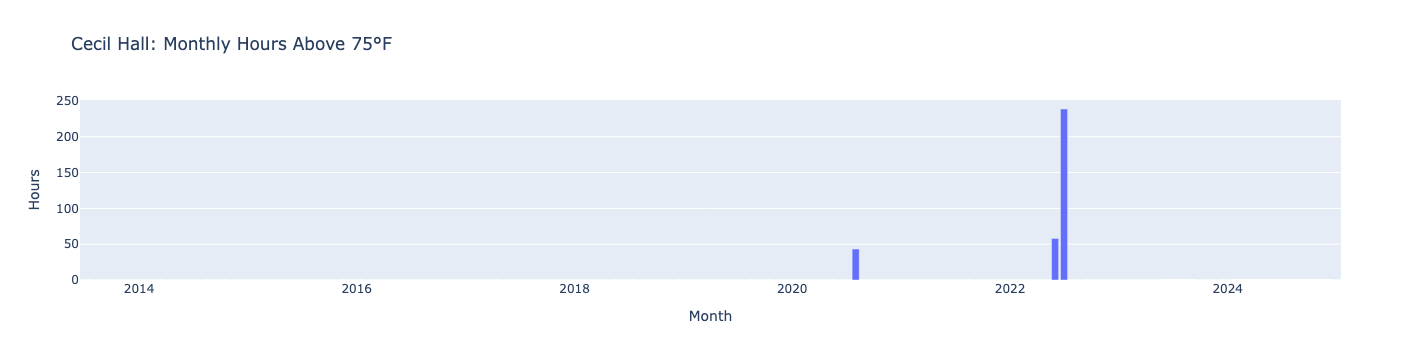

Fraktur: 129 months


/var/folders/2l/14yhlpvn4pv4rlg7jw32j4hm0000gn/T/ipykernel_33355/1635334190.py:27: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



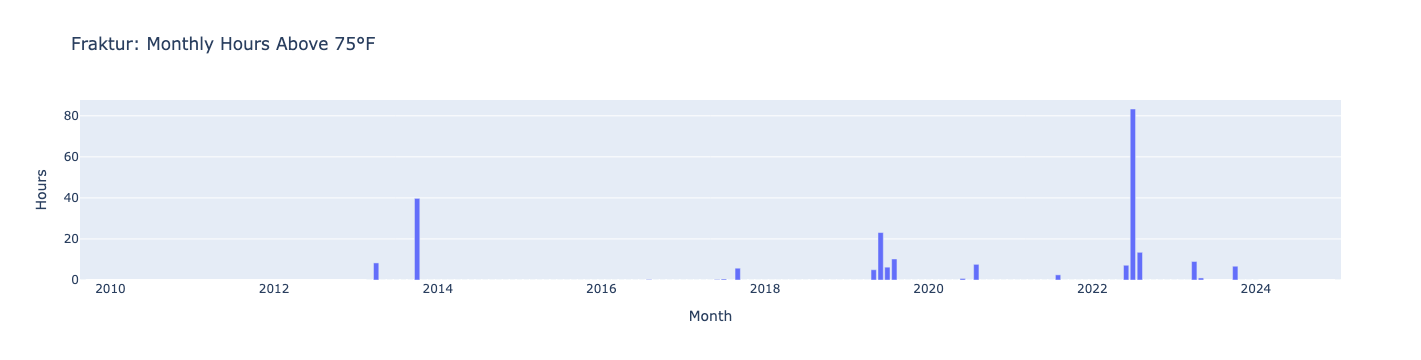

Readbourne Passage: 126 months


/var/folders/2l/14yhlpvn4pv4rlg7jw32j4hm0000gn/T/ipykernel_33355/1635334190.py:27: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



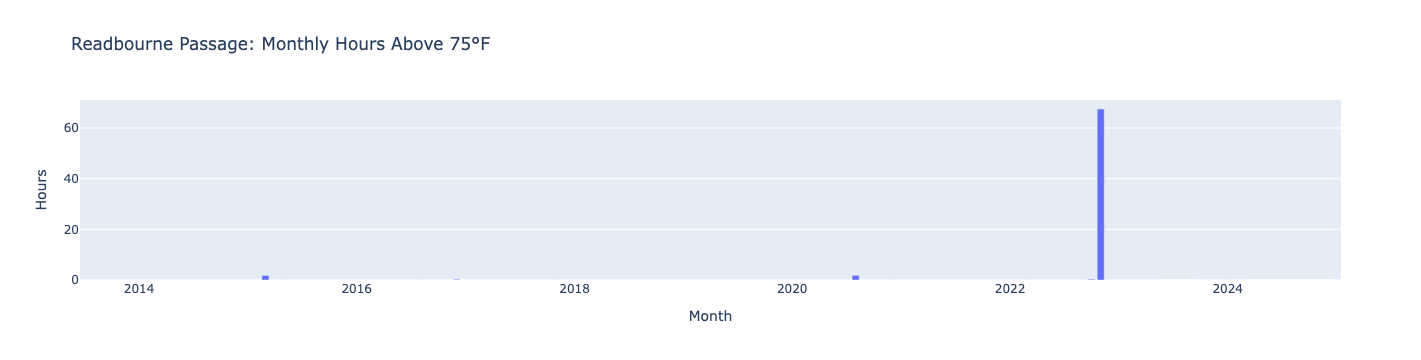

Nemours: 126 months


/var/folders/2l/14yhlpvn4pv4rlg7jw32j4hm0000gn/T/ipykernel_33355/1635334190.py:27: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



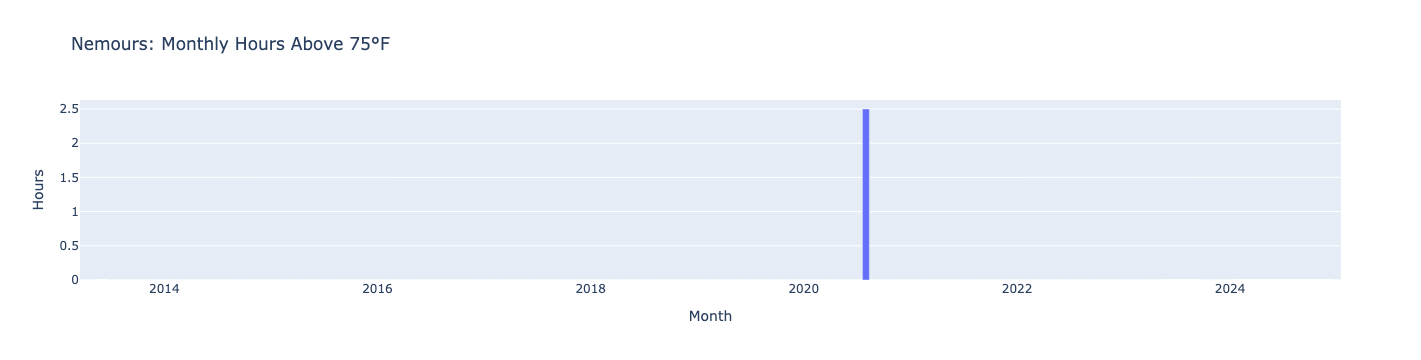

In [15]:
import pandas as pd
import plotly.graph_objects as go

HOT_THRESHOLD_F = 75.0
MIN_POINTS_PER_DAY = 8  # require at least 8 samples to count a day

# ---------- helpers ----------
def daily_hot_hours(df: pd.DataFrame,
                    threshold_f: float = HOT_THRESHOLD_F,
                    min_points_per_day: int = MIN_POINTS_PER_DAY) -> pd.DataFrame:
    """Approximate hot hours per day = (% samples above threshold) * 24."""
    g = df.assign(is_hot=df["Temp_F"] > threshold_f).groupby(df["Timestamp"].dt.date)
    out = pd.DataFrame({
        "Date": pd.to_datetime(list(g.groups.keys())),
        "pct_hot": g["is_hot"].mean().values,
        "n": g["is_hot"].count().values,
    })
    out = out[out["n"] >= min_points_per_day].copy()
    out["hot_hours"] = out["pct_hot"] * 24.0
    out["YearMonth"] = out["Date"].dt.to_period("M").astype(str)
    return out.sort_values("Date").reset_index(drop=True)

def monthly_summary(df: pd.DataFrame, threshold_f: float = HOT_THRESHOLD_F) -> pd.DataFrame:
    dly = daily_hot_hours(df, threshold_f=threshold_f)
    m = dly.groupby("YearMonth", as_index=False)["hot_hours"].sum()
    # add avg monthly temperature for context (optional)
    t = df.groupby(df["Timestamp"].dt.to_period("M"))["Temp_F"].mean().reset_index()
    t["YearMonth"] = t["Timestamp"].astype(str)
    t = t.drop(columns=["Timestamp"]).rename(columns={"Temp_F": "avg_temp_f"})
    return m.merge(t, on="YearMonth", how="left").sort_values("YearMonth")

def plot_monthly_hours(room: str, mdf: pd.DataFrame, threshold: float = HOT_THRESHOLD_F):
    fig = go.Figure()
    fig.add_bar(x=mdf["YearMonth"], y=mdf["hot_hours"], name=f"Hours > {int(threshold)}°F")
    fig.update_layout(
        title=f"{room}: Monthly Hours Above {int(threshold)}°F",
        xaxis_title="Month",
        yaxis_title="Hours",
        bargap=0.15,
        hovermode="x unified",
        showlegend=False
    )
    fig.show()

# ---------- build, plot, (optionally) save ----------
monthly_by_room = {}
for room, df in room_df.items():
    msum = monthly_summary(df, threshold_f=HOT_THRESHOLD_F)
    monthly_by_room[room] = msum
    print(f"{room}: {len(msum)} months")
    plot_monthly_hours(room, msum, threshold=HOT_THRESHOLD_F)

# Optional: save monthly tables to CSV
for room, mdf in monthly_by_room.items():
    mdf.to_csv(f"{room.replace(' ','_').lower()}_monthly_hot_hours.csv", index=False)


In [16]:
import pandas as pd
import numpy as np

def count_hot_days_by_consecutive_runs(
    df: pd.DataFrame,
    threshold_f: float = 75.0,
    min_consecutive_minutes: int = 45
) -> pd.DataFrame:
    """
    Returns a per-day table with a boolean 'is_hot_day' if the day contains
    at least one consecutive hot run lasting >= min_consecutive_minutes.
    Also returns the total number of such days.
    """
    if df.empty:
        return pd.DataFrame(columns=["Date", "is_hot_day", "longest_hot_run_min", "runs_this_day", "median_interval_min"])

    d = df.sort_values("Timestamp").copy()
    d["is_hot"] = d["Temp_F"] > threshold_f

    # Estimate typical sample spacing (minutes)
    median_dt = d["Timestamp"].diff().median()
    if pd.isna(median_dt) or median_dt.total_seconds() <= 0:
        # fallback if only one point
        median_dt = pd.Timedelta(minutes=15)
    step_min = median_dt.total_seconds() / 60.0

    # Allowable gap to still be "consecutive" (tolerant to jitter)
    max_gap = median_dt * 1.5

    # Identify starts of new runs: when hot flips off→on, or when gap too large
    prev_hot = d["is_hot"].shift(1).fillna(False)
    gaps = d["Timestamp"].diff().fillna(pd.Timedelta(seconds=0))
    new_run = (d["is_hot"] & (~prev_hot)) | (d["is_hot"] & (gaps > max_gap))

    # Run IDs only for hot segments
    d["hot_run_id"] = np.where(d["is_hot"], new_run.cumsum(), np.nan)

    # Summarize each hot run: duration ≈ (#points_in_run * median_interval)
    run_lengths = (
        d.loc[d["is_hot"]]
         .groupby("hot_run_id")
         .agg(
             first_ts=("Timestamp", "min"),
             last_ts=("Timestamp", "max"),
             n_points=("Timestamp", "size")
         )
         .reset_index(drop=True)
    )
    if run_lengths.empty:
        # No hot runs at all
        per_day = (d["Timestamp"].dt.date.value_counts()
                   .rename_axis("Date").rename("rows").reset_index()
                  ).assign(is_hot_day=False, longest_hot_run_min=0, runs_this_day=0, median_interval_min=step_min)
        return per_day[["Date", "is_hot_day", "longest_hot_run_min", "runs_this_day", "median_interval_min"]].sort_values("Date")

    # Duration by points * median step (more appropriate for discrete logs)
    run_lengths["run_minutes"] = run_lengths["n_points"] * step_min
    # Attribute each run to the date on which it starts (simple + fast).
    # (If you need exact day-splitting across midnight, we can refine later.)
    run_lengths["run_date"] = run_lengths["first_ts"].dt.date

    # Per-day: did any run reach the threshold? also track longest run that day
    day_runs = (run_lengths
                .groupby("run_date")
                .agg(
                    runs_this_day=("run_minutes", "size"),
                    longest_hot_run_min=("run_minutes", "max"),
                    any_reaching=("run_minutes", lambda x: (x >= min_consecutive_minutes).any())
                )
                .reset_index()
                .rename(columns={"run_date": "Date", "any_reaching": "is_hot_day"}))

    # Ensure every day present in the data appears, even if no hot runs
    all_days = pd.DataFrame({"Date": pd.to_datetime(d["Timestamp"].dt.date.unique())})
    day_runs["Date"] = pd.to_datetime(day_runs["Date"])
    per_day = (all_days.merge(day_runs, on="Date", how="left")
               .fillna({"runs_this_day": 0, "longest_hot_run_min": 0, "is_hot_day": False}))
    per_day["median_interval_min"] = step_min

    return per_day.sort_values("Date").reset_index(drop=True)


In [19]:
HOT_THRESHOLD_F = 75.0
MIN_CONSEC_MIN = 45

hot_day_tables = {}
for room, df in room_df.items():
    tbl = count_hot_days_by_consecutive_runs(df, HOT_THRESHOLD_F, MIN_CONSEC_MIN)
    hot_day_tables[room] = tbl
    n_hot_days = int(tbl["is_hot_day"].sum())
    print(f"{room}: {n_hot_days} hot days (≥ {MIN_CONSEC_MIN} min consecutive > {HOT_THRESHOLD_F}°F)")


Cecil Hall: 13 hot days (≥ 45 min consecutive > 75.0°F)
Fraktur: 29 hot days (≥ 45 min consecutive > 75.0°F)
Readbourne Passage: 3 hot days (≥ 45 min consecutive > 75.0°F)
Nemours: 1 hot days (≥ 45 min consecutive > 75.0°F)


In [18]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)


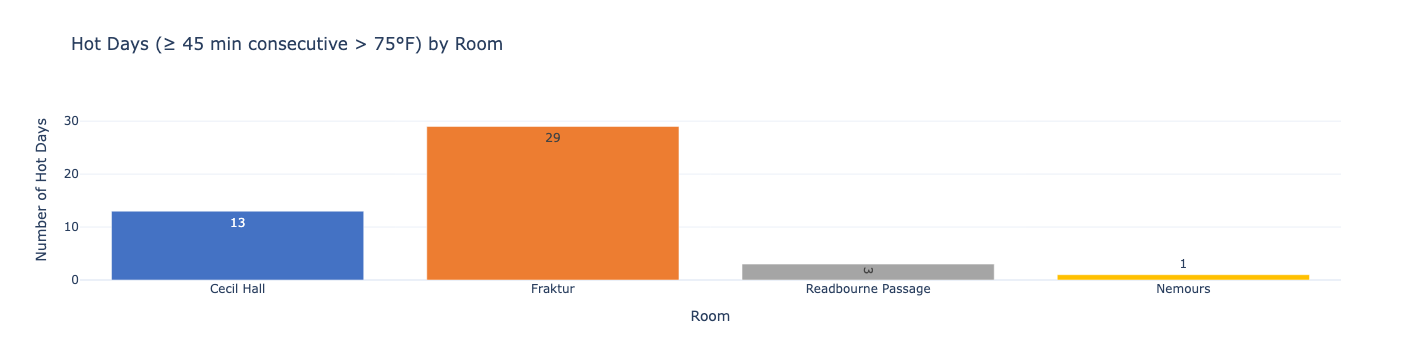

In [20]:
import plotly.graph_objects as go

# Your hot-day summary from the previous step
hot_day_counts = {
    "Cecil Hall": 13,
    "Fraktur": 29,
    "Readbourne Passage": 3,
    "Nemours": 1
}

fig = go.Figure()
fig.add_bar(
    x=list(hot_day_counts.keys()),
    y=list(hot_day_counts.values()),
    text=list(hot_day_counts.values()),
    textposition="auto",
    marker=dict(color=["#4472C4", "#ED7D31", "#A5A5A5", "#FFC000"])
)

fig.update_layout(
    title="Hot Days (≥ 45 min consecutive > 75°F) by Room",
    xaxis_title="Room",
    yaxis_title="Number of Hot Days",
    yaxis=dict(range=[0, max(hot_day_counts.values()) + 5]),
    template="plotly_white"
)
fig.show()


In [24]:
import pandas as pd

for room, df in room_df.items():
    # Get only the hot days for this room
    hot_tbl = hot_day_tables[room]
    hot_dates = set(pd.to_datetime(hot_tbl.loc[hot_tbl["is_hot_day"], "Date"]).dt.date)

    if not hot_dates:
        print(f"\n===== {room} =====")
        print("No hot days found.")
        continue

    # Prepare temperature summary per day (no n_points)
    df["DateOnly"] = df["Timestamp"].dt.date
    daily_stats = (
        df[df["DateOnly"].isin(hot_dates)]
        .groupby("DateOnly")["Temp_F"]
        .agg(avg_temp="mean", max_temp="max", min_temp="min")
        .reset_index()
        .sort_values("DateOnly")
    )

    print(f"\n===== {room} =====")
    print(
        daily_stats.to_string(
            index=False,
            formatters={
                "avg_temp": "{:.1f}".format,
                "max_temp": "{:.1f}".format,
                "min_temp": "{:.1f}".format
            }
        )
    )



===== Cecil Hall =====
  DateOnly   avg_temp max_temp min_temp
2020-08-10  74.331868     78.4     73.6
2022-06-27  74.895833     75.1     74.6
2022-06-28       75.1     75.5     74.7
2022-06-29  75.161333     75.5     74.9
2022-06-30      75.25     75.6     74.9
2022-07-01  75.410417     75.8     75.0
2022-07-03  75.556383     76.1     75.2
2022-07-04   75.53617     75.8     75.2
2022-07-05  75.276042     75.5     74.8
2022-07-06  75.506742     75.9     75.1
2022-07-07  75.497368     75.8     75.3
2022-07-08      75.51     75.8     75.2
2022-07-09  75.523404     75.8     75.4

===== Fraktur =====
  DateOnly   avg_temp max_temp min_temp
2013-04-11  72.445545     76.0     66.7
2013-10-03  72.996078     76.2     67.5
2013-10-04  73.142157     76.6     67.8
2013-10-05  73.556863     76.5     68.2
2013-10-06       73.6     77.6     67.6
2013-10-07  72.416667     76.8     66.7
2017-09-30  72.663542     76.2     70.1
2019-05-25  72.659375     75.7     69.6
2019-06-01  73.623958     76.5     